In [1]:
def imports():
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
    from env import user, password, host
    from sklearn.feature_selection import SelectKBest, f_regression, RFE
    from sklearn.linear_model import LinearRegression
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import os
    import csv
    import env
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from env import user, password, host
import env
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
imports()

In [4]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [5]:
def acquire_zillow():
    file='zillow_df.csv'
    if os.path.isfile(file):
        return pd.read_csv(file)
    else:
        zillow2017_df = pd.read_sql(('SELECT transactiondate,bathroomcnt,bedroomcnt,fips,calculatedfinishedsquarefeet,regionidzip,taxvaluedollarcnt FROM properties_2017 JOIN propertylandusetype USING (propertylandusetypeid) JOIN predictions_2017 USING (id) WHERE predictions_2017.transactiondate like "2017%%"'), get_connection('zillow'))
        zillow2017_df.to_csv(file,index=False)
    return zillow2017_df

In [6]:
zillow_df=acquire_zillow()
zillow_df.fips.nunique()

3

In [7]:
zillow_df.groupby('fips').sum()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,taxvaluedollarcnt
fips,,,,,
6037.0,115750.0,161625.0,93719421.0,5.020077e+09,2.212770e+10
6059.0,42277.5,57632.0,34728867.0,1.814541e+09,9.152360e+09
6111.0,13855.5,20100.0,11926310.0,6.333144e+08,2.520117e+09


In [8]:
def clean_column():
    zillow2017_df=acquire_zillow()
    zillow2017_df.rename(columns={'bedroomcnt':'bedroom','bathroomcnt':'bathroom','calculatedfinishedsquarefeet':'sqtft','taxvaluedollarcnt':'taxvalue','garagecarcnt':'garage','lotsizesquarefeet':'lots','poolcnt':'pool','regionidzip':'zipcode'},inplace=True)
    zillow2017_df['fips']= zillow2017_df['fips'].astype(object)
    value=[]
    for row in zillow2017_df['fips']:
        if row ==6037.0: value.append('Los Angeles County, CA')
        elif row == 6059.0: value.append("Orange County, CA")
        elif row == 6111.0: value.append('Ventura County, CA')
        else:
            value.append('Undetermined')
    zillow2017_df['county']=value
    zillow2017_df['zipcode']=zillow2017_df['zipcode'].astype(object)
    return zillow2017_df

In [9]:
def remove_outlier(k):
    zillow2017_df=clean_column()
    col_list=zillow2017_df.select_dtypes(float)
    for col in col_list:
        q1, q3 = zillow2017_df[col].quantile([.25, .75]) 
        iqr = q3 - q1  
        upper_bound = q3 + k * iqr  
        lower_bound = q1 - k * iqr  
        zillow2017_df = zillow2017_df[(zillow2017_df[col] > lower_bound) & (zillow2017_df[col] < upper_bound)]
        zillow2017_df.dropna()
    return zillow2017_df

In [10]:
def get_hist(k):
    zillow2017_df=remove_outlier(k)
    plt.figure(figsize=(16, 3))
    cols = zillow2017_df.select_dtypes(float).columns
    for i, col in enumerate(cols):
        plot_num = i + 1 
        plt.subplot(1, len(cols), plot_num)
        plt.title(col)
        zillow2017_df[col].hist(bins=5)
        plt.grid(False)
        plt.ticklabel_format(useOffset=False)
        plt.tight_layout()
    plt.show()

In [11]:
def wrangle_zillow(k):
    zillow2017_df=remove_outlier(k)
    get_hist(k)
    train_validate, zillow_test = train_test_split(zillow2017_df, test_size=.2, random_state=123)
    zillow_train, zillow_validate = train_test_split(train_validate, test_size=.3, random_state=123)
    return zillow_train, zillow_validate, zillow_test

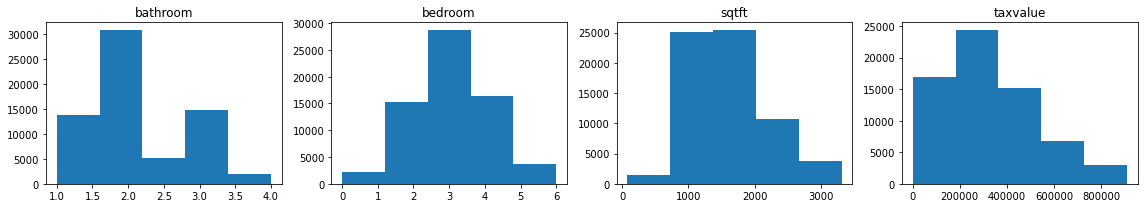

In [12]:
zillow_train,zillow_validate,zillow_test=wrangle_zillow(1.5)

In [13]:
zillow_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37185 entries, 20929 to 18863
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   transactiondate  37185 non-null  object 
 1   bathroom         37185 non-null  float64
 2   bedroom          37185 non-null  float64
 3   fips             37185 non-null  object 
 4   sqtft            37185 non-null  float64
 5   zipcode          37112 non-null  object 
 6   taxvalue         37185 non-null  float64
 7   county           37185 non-null  object 
dtypes: float64(4), object(4)
memory usage: 2.6+ MB


In [14]:
zillow_train.county.value_counts()

Los Angeles County, CA    25205
Orange County, CA          8841
Ventura County, CA         3139
Name: county, dtype: int64

In [15]:
zillow_train.transactiondate

20929    2017-03-28
68044    2017-08-18
47591    2017-06-16
2635     2017-01-12
12678    2017-02-27
            ...    
34520    2017-05-09
351      2017-01-03
24696    2017-04-07
60017    2017-07-24
18863    2017-03-21
Name: transactiondate, Length: 37185, dtype: object

In [16]:
zillow_train.transactiondate.value_counts()

2017-06-30    590
2017-07-28    442
2017-06-16    435
2017-05-31    432
2017-03-31    429
             ... 
2017-03-26      1
2017-04-02      1
2017-03-25      1
2017-05-06      1
2017-01-14      1
Name: transactiondate, Length: 247, dtype: int64